# Modeling Work 2 for Logreg

Modeling Work 1 is mostly done onto all features. These models will have select features used instead as I believe there was a bunch of unnecessary noise in the models of Modeling Work 1

## Imports and functions

In [1]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report

from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [2]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [3]:
ft_df = pd.read_csv("../data/training_set_features.csv")
lbl_df = pd.read_csv("../data/training_set_labels.csv")
## Merging dfs
df_merged = ft_df.merge(lbl_df)

In [4]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

## Prepping data to use

In [5]:
df_merged['health_insurance'].fillna(0).value_counts()

0.0    14010
1.0    12697
Name: health_insurance, dtype: int64

In [6]:
df_merged['health_insurance'].value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

In [7]:
df_merged.groupby(['education','income_poverty']).count()

respondent_id  h1n1_concern  \
education        income_poverty                                           
12 Years         <= $75,000, Above Poverty           3266          3261   
                 > $75,000                            646           646   
                 Below Poverty                        934           932   
< 12 Years       <= $75,000, Above Poverty            956           952   
                 > $75,000                            126           126   
                 Below Poverty                        807           797   
College Graduate <= $75,000, Above Poverty           4407          4403   
                 > $75,000                           4500          4496   
                 Below Poverty                        271           270   
Some College     <= $75,000, Above Poverty           4101          4093   
                 > $75,000                           1524          1524   
                 Below Poverty                        662           660   

                                            h1n1_knowledge  \
education        income_poverty                              
12 Years         <= $75,000, Above Poverty            3255   
                 > $75,000                             644   
                 Below Poverty                         930   
< 12 Years       <= $75,000, Above Poverty             952   
                 > $75,000                             125   
                 Below Poverty                         795   
College Graduate <= $75,000, Above Poverty            4397   
                 > $75,000                            4489   
                 Below Poverty                         271   
Some College     <= $75,000, Above Poverty            4089   
                 > $75,000                            1520   
                 Below Poverty                         659   

                                            behavioral_antiviral_meds  \
education        income_poverty                                         
12 Years         <= $75,000, Above Poverty                       3257   
                 > $75,000                                        644   
                 Below Poverty                                    931   
< 12 Years       <= $75,000, Above Poverty                        954   
                 > $75,000                                        126   
                 Below Poverty                                    801   
College Graduate <= $75,000, Above Poverty                       4402   
                 > $75,000                                       4495   
                 Below Poverty                                    269   
Some College     <= $75,000, Above Poverty                       4090   
                 > $75,000                                       1521   
                 Below Poverty                                    661   

                                            behavioral_avoidance  \
education        income_poverty                                    
12 Years         <= $75,000, Above Poverty                  3241   
                 > $75,000                                   643   
                 Below Poverty                               926   
< 12 Years       <= $75,000, Above Poverty                   952   
                 > $75,000                                   126   
                 Below Poverty                               801   
College Graduate <= $75,000, Above Poverty                  4380   
                 > $75,000                                  4466   
                 Below Poverty                               268   
Some College     <= $75,000, Above Poverty                  4077   
                 > $75,000                                  1518   
                 Below Poverty                               658   

                                            behavioral_face_mask  \
education        income_poverty                                    
12 Years    

In [8]:
## Dropping:
# respondent_id: its just ids
# employment_occupation/industry: too many nulls, assuming imputing with most freq will give us wrong data
# health insurance: too many nulls again, cant really decide if they have or dont have insurance
df_noid = df_merged.drop(['respondent_id','employment_occupation','employment_industry','behavioral_antiviral_meds',
                          'household_children','household_adults','census_msa','rent_or_own', 'marital_status',
                         'health_insurance'], axis = 1)

## Creating train test valid

In [9]:
# preparing X and y
X = df_noid.drop('h1n1_vaccine', axis = 1)
y = df_noid['h1n1_vaccine']

In [10]:
# initial split between test and rest. Final untouced data will be X_test/y_test
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)
# Splitting again for cross validation. X_train/X_valid will be used mostly
X_train, X_valid, y_train, y_valid = train_test_split(X_train_temp, y_train_temp, random_state = 42)

In [11]:
print(f"Sum of X_'s: {len(X_test)+len(X_train)+len(X_valid)}")
print(f"Length of df: {len(df_noid)}")

# Just checking if logic of trian/test/split worked correctly

Sum of X_'s: 26707
Length of df: 26707


## Creating initial pipes

In [12]:
# Every feature has some kind of null. Will have to impute first.
# Making pipelines for imputers
# Will also scale here

subpipe_num = Pipeline(steps = [
    ('num_impute', SimpleImputer(strategy = 'median')),
    ('ss', StandardScaler())
])

subpipe_cat = Pipeline(steps = [
    ('cat_impute', SimpleImputer(strategy = 'most_frequent')),
    
    ('ohe', OneHotEncoder(sparse = False, handle_unknown = 'ignore'))
])

In [13]:
# Col transformer will handle preprocessing
# Add model at end of the pipeline

CT = ColumnTransformer(transformers = [
    ('subpipe_num', subpipe_num, selector(dtype_include = np.number)),
    ('subpipe_cat', subpipe_cat, selector(dtype_include = object))
], remainder = 'passthrough')

## Dummy Model of new features

In [14]:
dummy_model_pipe = Pipeline(steps = [
    ('ct',CT),
    ('dummy', DummyClassifier(strategy = 'most_frequent'))
])

In [15]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F50DA937F0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

In [16]:
dummy_model_pipe.score(X_train, y_train)

0.7851001275863981

CV Results for `dummy` model:
            0.78510 ± 0.00025 accuracy
        


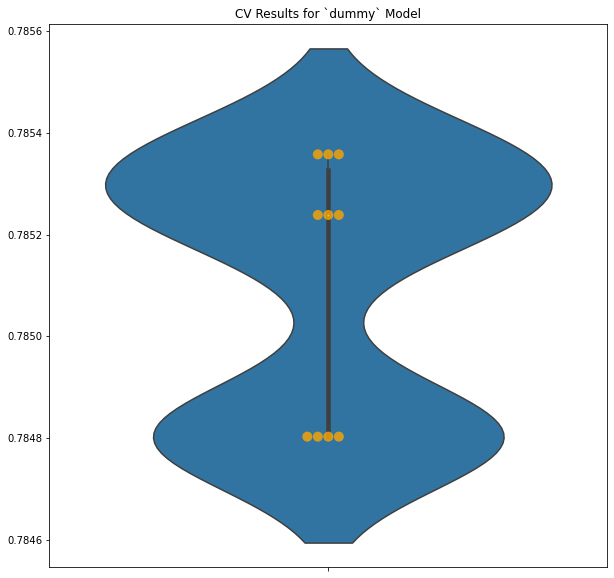

In [17]:
dummy_pipe = ModelWithCV(
    dummy_model_pipe,
model_name = 'dummy',
X = X_train,
y = y_train)
fig, ax = plt.subplots(figsize = (10,10))
dummy_pipe.plot_cv(ax=ax)
dummy_pipe.print_cv_summary()

In [18]:
dummy_model_pipe.score(X_valid, y_valid)

0.7956398735230488

In [19]:
y_pred = dummy_model_pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      4781
           1       0.00      0.00      0.00      1228

    accuracy                           0.80      6009
   macro avg       0.40      0.50      0.44      6009
weighted avg       0.63      0.80      0.71      6009



F:\Anaconda\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


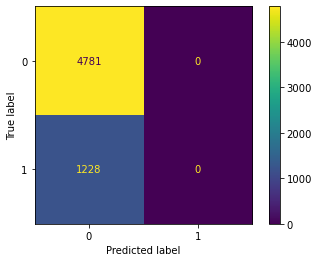

In [20]:
plot_confusion_matrix(dummy_model_pipe, X_valid, y_valid)

## Logreg model no params

In [21]:
logreg_basic_model_pipe = Pipeline(steps = [
    ('ct', CT),
    ('logreg_basic', LogisticRegression())
])

In [22]:
logreg_basic_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F50DA937F0>),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                       

CV Results for `logreg_basic_with_cv` model:
            0.84978 ± 0.00777 accuracy
        


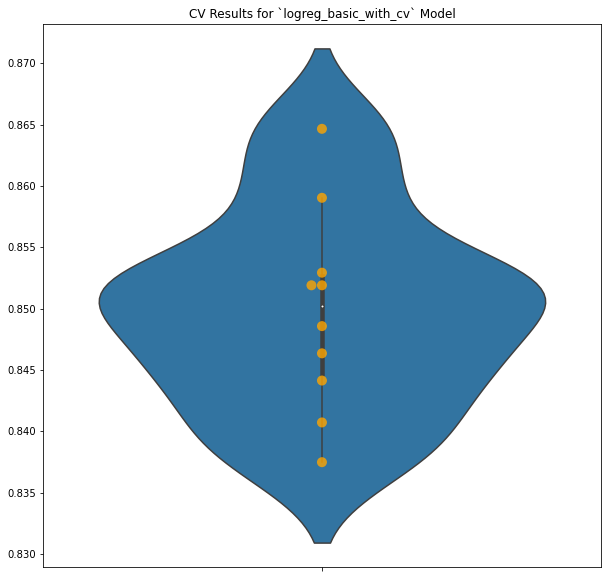

In [23]:
logreg_basic_cv = ModelWithCV(
    logreg_basic_model_pipe,
model_name = 'logreg_basic_with_cv',
X = X_train,
y = y_train)
fig, ax = plt.subplots(figsize = (10,10))
logreg_basic_cv.plot_cv(ax=ax)
logreg_basic_cv.print_cv_summary()

In [24]:
logreg_basic_model_pipe.score(X_valid, y_valid)

0.8525545015809619

In [25]:
y_pred = logreg_basic_model_pipe.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4781
           1       0.69      0.50      0.58      1228

    accuracy                           0.85      6009
   macro avg       0.79      0.72      0.74      6009
weighted avg       0.84      0.85      0.84      6009



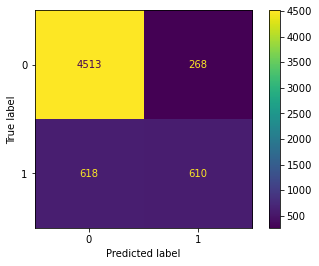

In [26]:
plot_confusion_matrix(logreg_basic_model_pipe, X_valid, y_valid)

- True no vacc:   4513
- False no vacc:  618
- True yes vacc:  610
- False yes vacc: 268


- We guessed 878 would get vaccine, 268 was wrong
- We guessed 5131 would not get vacc, 618 was wrong.

### Begin Gridsearching and tuning on logreg

In [27]:
params = {}
params['ct__subpipe_num__num_impute__strategy'] = ['median']
params['logreg_basic__penalty'] = ['l2'] 
params['logreg_basic__max_iter'] = [100]
params['logreg_basic__C'] = [0.075]
params['logreg_basic__solver'] = ['saga']
params['logreg_basic__tol'] = [0.0001]
gs = GridSearchCV(estimator = logreg_basic_model_pipe,
               param_grid = params,
               cv = 10,)

In [28]:
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001F50DA937F0>),
                                                                        ('subpipe_cat',
                                                                         Pip

In [29]:
gs.best_params_

{'ct__subpipe_num__num_impute__strategy': 'median',
 'logreg_basic__C': 0.075,
 'logreg_basic__max_iter': 100,
 'logreg_basic__penalty': 'l2',
 'logreg_basic__solver': 'saga',
 'logreg_basic__tol': 0.0001}

CV Results for `gs_dtc_model` model:
            0.85056 ± 0.00781 accuracy
        


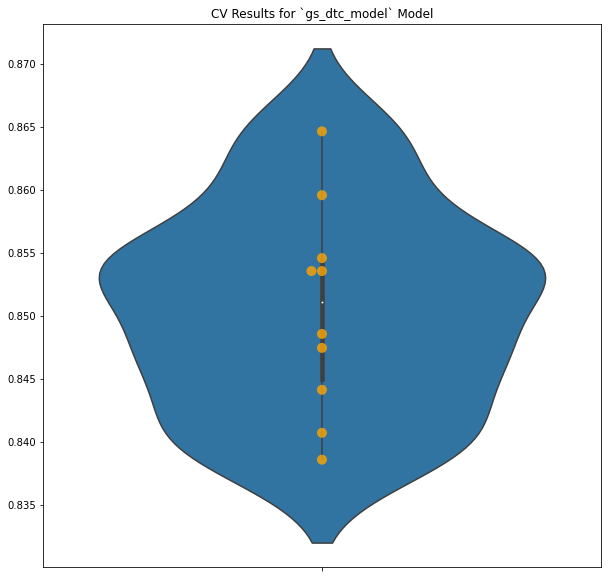

In [30]:
gs_pipe = ModelWithCV(
    gs.best_estimator_,
    model_name='gs_dtc_model',
    X=X_train,
    y=y_train)
fix, ax = plt.subplots(figsize=(10,10))

gs_pipe.plot_cv(ax=ax)
gs_pipe.print_cv_summary()

In [31]:
gs_pipe.print_cv_summary()

CV Results for `gs_dtc_model` model:
            0.85056 ± 0.00781 accuracy
        


In [32]:
gs.best_estimator_.score(X_valid, y_valid)

0.853053752704277

In [33]:
y_pred = gs.best_estimator_.predict(X_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4781
           1       0.70      0.50      0.58      1228

    accuracy                           0.85      6009
   macro avg       0.79      0.72      0.75      6009
weighted avg       0.84      0.85      0.84      6009



Iteration best model Confusion Matrix


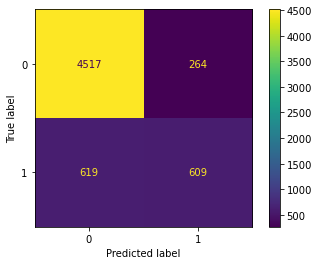

In [34]:
plot_confusion_matrix(gs.best_estimator_, X_valid, y_valid)
print(f"Iteration best model Confusion Matrix")
#plt.savefig('Modeling_Work_2_Logreg_best.png')